# Setup

## Download Pretrained Embeddings

### Glove

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip

In [ ]:
!unzip glove.840B.300d.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
!unzip glove.twitter.27B.zip

### Word2Vec

In [ ]:
!wget https://github.com/piskvorky/gensim-data/releases/download/word2vec-google-news-300/word2vec-google-news-300.gz

In [ ]:
!gzip -d word2vec-google-news-300.gz

### FastText

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [ ]:
!unzip wiki-news-300d-1M.vec.zip

## Python Imports

In [13]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, Flatten, Dense
from keras.layers import GlobalAveragePooling1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

## Global Funtions/Variables

In [ ]:
# "Tried and tested competition values
globalEpoch = 4
globalBatchSize = 32

In [9]:
def load_glove_vectors(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [4]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Prepare Dataset

In [5]:
# Load the train dataset
train_df = pd.read_csv('dataset/train.csv')

# Load the test dataset
test_df = pd.read_csv('dataset/test.csv')

# Load the test labels
test_labels_df = pd.read_csv('dataset/test_labels.csv')

# Filter out rows in test_labels where all label columns are -1
mask = (test_labels_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == -1).all(axis=1)
test_labels_df = test_labels_df[~mask]

# Now join test_df and test_labels_df on 'id' to get the final test dataset
test_df = pd.merge(test_df, test_labels_df, on='id')

In [6]:
# Access the 'comment_text' column in the train dataset
train_text = train_df['comment_text'].astype(str)

# Access the 'comment_text' column in the test dataset
test_text = test_df['comment_text'].astype(str)

# Access the labels in the train dataset
train_labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Access the labels in the test dataset
test_labels = test_labels_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [7]:
tokenizer = Tokenizer()

# Fit the tokenizer on the text data (both train and test)
# This will create the vocabulary index based on word frequency
tokenizer.fit_on_texts(pd.concat([train_text, test_text]))

# Transform each text in train_text to a sequence of integers with its corresponding integer value from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(train_text)

# Transform each text in test_text to a sequence of integers with its corresponding integer value from the word_index dictionary
test_sequences = tokenizer.texts_to_sequences(test_text)

# Transform each sequence in train_sequences to the same length
# This is done by padding sequences that are shorter than the longest sequence, and truncating sequences that are longer
train_data = pad_sequences(train_sequences)

# Transform each sequence in test_sequences to the same length as the sequences in train_data
# This is done by padding or truncating as necessary
test_data = pad_sequences(test_sequences, maxlen=train_data.shape[1])

word_index = tokenizer.word_index
nb_words = len(tokenizer.word_index) + 1

# Glove

In [10]:
embeddings = load_glove_vectors("glove.6B.300d.txt")
embedding_dim = 300 

embedding_matrix = np.zeros((nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Pre-trained

In [17]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))
model.layers[0].trainable = False

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         93445500  
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 1806      
                                                                 
Total params: 93,447,306
Trainable params: 1,806
Non-trainable params: 93,445,500
_________________________________________________________________


Epoch 1/4
4488/4488 [==============================] - 15s 3ms/step - loss: 0.2398 - acc: 0.9558 - val_loss: 0.1490 - val_acc: 0.9940
Epoch 2/4
4488/4488 [==============================] - 14s 3ms/step - loss: 0.1386 - acc: 0.9942 - val_loss: 0.1358 - val_acc: 0.9940
Epoch 3/4
4488/4488 [==============================] - 14s 3ms/step - loss: 0.1322 - acc: 0.9936 - val_loss: 0.1329 - val_acc: 0.9903
Epoch 4/4
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1349 - acc: 0.9905
Test accuracy: 0.9905436038970947


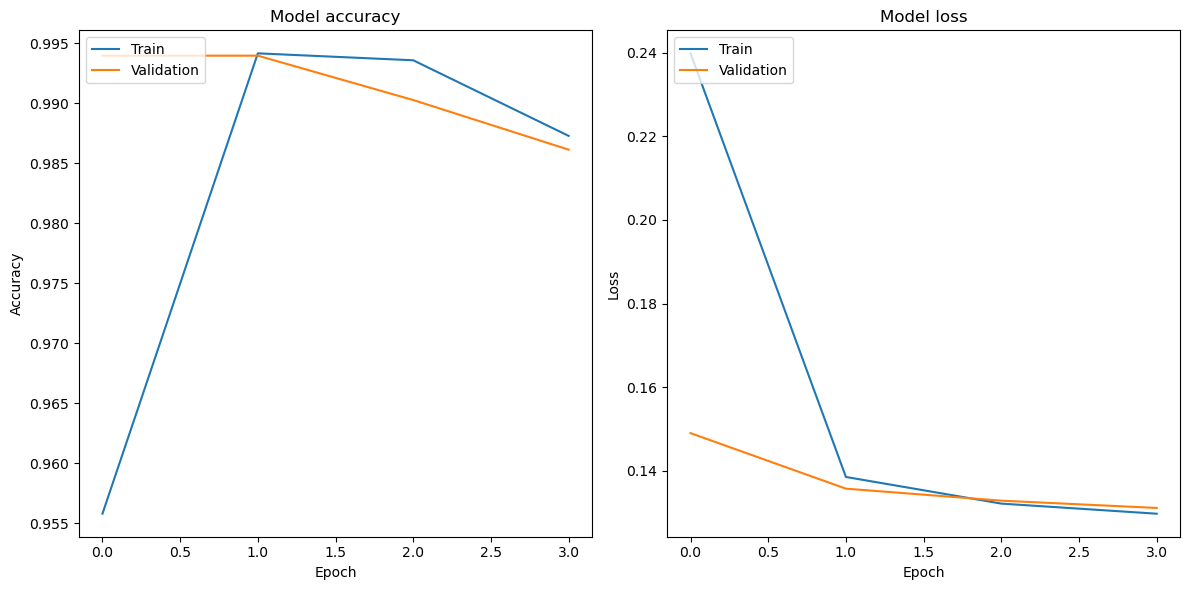

In [18]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('glove-6B-300d-Pre-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')

## Re-trained

In [19]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         93445500  
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 6)                 1806      
                                                                 
Total params: 93,447,306
Trainable params: 93,447,306
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('glove-6B-300d-Re-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')

Epoch 1/4
1320/4488 [=======>......................] - ETA: 1:05 - loss: 0.1560 - acc: 0.9634

# Word2Vec

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('word2vec-google-news-300', binary=True)
embedding_dim = 300

embedding_matrix = np.zeros((nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

## Pre-trained

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))
model.layers[0].trainable = False

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('word2vec-google-news-300-Pre-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')

## Re-trained

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('word2vec-google-news-300-Re-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')

# FastText

In [ ]:
fasttext = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')
embedding_dim = 300

embedding_matrix = np.zeros((nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    if word in fasttext:
        embedding_matrix[i] = fasttext[word]

## Pre-trained

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))
model.layers[0].trainable = False

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('wiki-news-300d-1M-Pre-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')

## Re-trained

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embedding_dim, weights=[embedding_matrix]))

model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(train_data, train_labels, epochs=globalEpoch, batch_size=globalBatchSize, validation_split=0.1)

loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

plot_history(history)

model.save('wiki-news-300d-1M-Re-trained.keras')

# # Load the model
# loaded_model = load_model('path_to_my_model')